# Spike Gadgets Ephys and Video Syncing

In [1]:
import os
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings

In [2]:
import numpy as np
import pandas as pd
# import cv2
from IPython.display import Video
import matplotlib.pyplot as plt
import janitor

In [3]:
# setting path
sys.path.append('../../../src')

In [4]:
%matplotlib inline

In [5]:
import spikeinterface

In [6]:
import spikeinterface as si  # import core only
import spikeinterface.extractors as se
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw

/tmp/ipykernel_3327137/634830499.py:3: DeprecationWarning: The 'toolkit' module is deprecated. Use spikeinterface.preprocessing/postptocessing/qualitymetrics instead
  import spikeinterface.toolkit as st


In [7]:
import spikeinterface.core

In [8]:
from probeinterface import get_probe
from probeinterface.plotting import plot_probe, plot_probe_group
from probeinterface import write_prb, read_prb

In [9]:
import spikeinterface.full as si

## Metadata

In [10]:
subject_id = "6.1"
recording_date = "20221214"

# Reading in the Timestamp Information

In [11]:
tone_label_file_ending = "tone_label_df"

In [12]:
tone_label_path = glob.glob("./proc/*{}.csv*".format(tone_label_file_ending))[0]

In [13]:
tone_label_path

'./proc/20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3_tone_label_df.csv'

In [14]:
recording_name = os.path.splitext(os.path.basename(tone_label_path))[0].strip(tone_label_file_ending)

In [15]:
recording_name

'20221214_125409_om_and_comp_6_1_top_1_base_2_vs_6_3'

In [16]:
tone_time_stamps_df = pd.read_csv(tone_label_path, index_col=0)

In [17]:
tone_time_stamps_df

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785
5,9908037,rewarded,485.40185,-844.52800
6,11808035,rewarded,580.40175,-749.52810
7,13608031,rewarded,670.40155,-659.52830
8,15208032,omission,750.40160,-579.52825
9,17008029,rewarded,840.40145,-489.52840


# Reading in Phy

- Which unit the spike came from

In [18]:
spike_clusters_path = glob.glob("./proc/**/phy/spike_clusters.npy", recursive=True)[0]

In [19]:
spike_clusters_path[0]

'.'

In [20]:
spike_clusters = np.load(spike_clusters_path)

In [21]:
spike_clusters[:10]

array([ 39, 170,  60,  60,  88, 183,  19,  67, 174,  20], dtype=int32)

- The classification of each unit

In [22]:
cluster_info_path = glob.glob("./proc/**/phy/cluster_info.tsv", recursive=True)[0]

In [23]:
cluster_group_df = pd.read_csv(cluster_info_path, sep="\t")

In [24]:
cluster_group_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
0,0,427.0,0,0.0,0.0,0.263283,noise,844,0,1.0
1,2,188.0,1,0.0,20.0,1.147027,mua,3677,0,3.0
2,3,193.0,1,0.0,20.0,0.859724,noise,2756,0,4.0
3,4,871.0,2,0.0,40.0,12.211762,mua,39147,0,5.0
4,5,504.0,2,0.0,40.0,3.960782,mua,12697,0,6.0
...,...,...,...,...,...,...,...,...,...,...
93,183,932.0,29,0.0,580.0,9.470066,good,30358,0,73.0
94,187,568.0,6,0.0,120.0,0.096079,mua,308,0,19.0
95,188,568.0,6,0.0,120.0,0.664446,good,2130,0,19.0
96,197,932.0,29,0.0,580.0,0.351563,mua,1127,0,73.0


- Filtering for the good units

In [25]:
good_unit_cluster_info_df = cluster_group_df[cluster_group_df["group"] == "good"]

In [26]:
good_unit_cluster_info_df

,cluster_id,amp,ch,channel_group,depth,fr,group,n_spikes,sh,si_unit_id
15,16,1147.5,6,0.0,120.0,0.864403,good,2771,0,17.0
18,20,1113.0,7,0.0,140.0,5.995296,good,19219,0,21.0
22,24,1206.0,9,0.0,180.0,5.371091,good,17218,0,25.0
35,50,1644.0,21,0.0,420.0,1.107409,good,3550,0,51.0
36,52,870.0,21,0.0,420.0,1.168551,good,3746,0,53.0
38,54,448.5,22,0.0,440.0,7.901600,good,25330,0,55.0
43,59,253.0,24,0.0,480.0,1.836116,good,5886,0,60.0
47,64,633.0,26,0.0,520.0,2.901412,good,9301,0,65.0
81,156,440.0,19,0.0,380.0,0.868770,good,2785,0,47.0
84,163,542.0,21,0.0,420.0,1.598101,good,5123,0,52.0


In [27]:
good_unit_unique_ids = good_unit_cluster_info_df["cluster_id"].values

In [28]:
good_unit_unique_ids

array([ 16,  20,  24,  50,  52,  54,  59,  64, 156, 163, 174, 182, 183,
       188])

- The times that all the spikes happened

In [29]:
spike_time_path = glob.glob("./proc/**/phy/spike_times.npy", recursive=True)[0]

In [30]:
spike_times = np.load(spike_time_path)

In [31]:
spike_times[:10]

array([[ 11],
       [ 89],
       [143],
       [178],
       [215],
       [260],
       [309],
       [344],
       [413],
       [487]])

- Getting a list of the IDs that were good from the list of unit ids for all the firings

In [32]:
good_unit_mask = np.isin(spike_clusters, good_unit_unique_ids)

In [33]:
good_unit_all_ids = spike_clusters[good_unit_mask]

In [34]:
good_unit_all_ids.shape

(172619,)

In [35]:
good_unit_all_ids[:10]

array([183, 174,  20, 183,  24, 182, 183,  54,  54,  64], dtype=int32)

- Getting the time that the good units fired

In [36]:
good_unit_times = spike_times[good_unit_mask].T[0]

In [37]:
good_unit_times.shape

(172619,)

In [38]:
good_unit_times[:10]

array([ 260,  413,  487,  821, 1190, 1588, 1640, 1701, 2087, 2467])

In [39]:
good_unit_times[-10:]

array([64108851, 64109062, 64109114, 64109909, 64110757, 64110943,
       64111416, 64112221, 64112277, 64113530])

- spike_times are indexed based on the start of the recording, not the start of the streaming
    - Last spike ends right before the end of the recording time

In [40]:
spike_times

array([[      11],
       [      89],
       [     143],
       ...,
       [64113456],
       [64113530],
       [64113594]])

In [41]:
spike_times[-1]/20000

array([3205.6797])

## Syncing the unit times with the ECU times

In [42]:
tone_time_stamps = tone_time_stamps_df["tone_time_stamp"].values

In [43]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

## Seeing which tone time each unit time is closest to

- We will divide all the time up into bins of before and after each tone. Then we will see which time bin the neuron firing falls into.
    - So everything in the 0 bin would be before the first time bin. The 1 bin would be everything in between the first and second time bin. The last would be everything after last time bin.

In [44]:
good_unit_bins = np.digitize(good_unit_times, tone_time_stamps_df["tone_time_stamp"], right=True)

In [45]:
good_unit_bins.shape

(172619,)

In [46]:
good_unit_bins[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [47]:
good_unit_bins[-10:]

array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33])

- Seeing if the firing time is within a 10 second interval before or 10 second after any tone

In [48]:
from collections import defaultdict

In [49]:
good_unit_bins.shape

(172619,)

In [50]:
good_unit_times.shape

(172619,)

In [51]:
good_unit_all_ids.shape

(172619,)

In [52]:
good_unit_times[:10]

array([ 260,  413,  487,  821, 1190, 1588, 1640, 1701, 2087, 2467])

In [53]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [54]:
len(tone_time_stamps)

33

# Comparing Firing Rate between Trial types

In [55]:
tone_time_stamps_df.head()

,tone_time_stamp,tone_category,tone_clock_time_omission,tone_clock_time_comp
0,1408048,rewarded,60.40240,-1269.52745
1,3008051,rewarded,140.40255,-1189.52730
2,4808043,rewarded,230.40215,-1099.52770
3,6408042,omission,310.40210,-1019.52775
4,7908040,rewarded,385.40200,-944.52785


In [56]:
good_unit_times

array([     260,      413,      487, ..., 64112221, 64112277, 64113530])

In [57]:
good_unit_all_ids

array([183, 174,  20, ..., 183, 174,  54], dtype=int32)

In [58]:
good_unit_bins

array([ 0,  0,  0, ..., 33, 33, 33])

In [59]:
tone_time_stamps

array([ 1408048,  3008051,  4808043,  6408042,  7908040,  9908037,
       11808035, 13608031, 15208032, 17008029, 19008027, 20808026,
       23208023, 25008021, 27998597, 29598593, 31398591, 32998593,
       34498591, 36498588, 38398586, 40198584, 41798580, 43598581,
       45598579, 47398577, 49798572, 51598570, 53298568, 55098566,
       56998564, 59398564, 60998563])

In [60]:
"""
Step 1: 
- Get all the unit times that are 10 seconds before tone 
and 10 seconds after the tone(separately)

Step 2:
- Separate out for each trial

Step 3: Calculate firing rate
"""

'\nStep 1: \n- Get all the unit times that are 10 seconds before tone \nand 10 seconds after the tone(separately)\n\nStep 2:\n- Separate out for each trial\n\nStep 3: Calculate firing rate\n'

- Duration to include before and after tone

In [61]:
# time in seconds
trial_one_way_duration = 10

In [62]:
sampling_rate = 20000

- Getting the number of samples before and after to include for each tone

In [63]:
per_trial_number_of_samples = trial_one_way_duration * sampling_rate

In [64]:
per_trial_number_of_samples

200000

- Getting all the tones that fired within before or after the number of samples

In [65]:
before_or_after_column = "before_or_after"

In [66]:
# iterating through the timestamp of each good unit spike

before_and_after_interval_unit_times = defaultdict(dict)


for index, time in enumerate(good_unit_times):
    # getting the corresponding tone bin for the timestamp
    current_bin = good_unit_bins[index]
    current_neuron = good_unit_all_ids[index]   
#     print("Current Bin: {}".format(current_bin))
    
    # checking number before
    first_tone_time = tone_time_stamps[(current_bin - 1) % len(tone_time_stamps)]
    # checking number after
    second_tone_time = tone_time_stamps[(current_bin) % len(tone_time_stamps)]    
    
#     print("Time: {}, First tone time: {} Second tone time: {}".format(time, first_tone_time, second_tone_time))
    
    
    # checking if time is before first number
    if first_tone_time - per_trial_number_of_samples <= time <= first_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after first number
    elif first_tone_time < time <= first_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = first_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    
    # checking if time is before second number
    elif second_tone_time - per_trial_number_of_samples <= time <= second_tone_time:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "before"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    # checking if time is after second number
    elif second_tone_time < time <= second_tone_time + per_trial_number_of_samples:
        before_and_after_interval_unit_times[time]["tone_time"] = second_tone_time
        before_and_after_interval_unit_times[time][before_or_after_column] = "after"
        before_and_after_interval_unit_times[time]["neuron_id"] = good_unit_all_ids[index]
    else:
        continue


In [67]:
per_trial_number_of_samples

200000

In [68]:
before_and_after_interval_unit_df = pd.DataFrame.from_dict(before_and_after_interval_unit_times, orient="index").reset_index()
before_and_after_interval_unit_df = before_and_after_interval_unit_df.rename(columns={"index": "spike_time"})

In [69]:
before_and_after_interval_unit_df.head()

,spike_time,tone_time,before_or_after,neuron_id
0,1209073,1408048,before,64
1,1210306,1408048,before,54
2,1210810,1408048,before,174
3,1211041,1408048,before,52
4,1212118,1408048,before,54


- Getting the count of each neuron that fired during the tone interval grouped by the neuron's ID

In [70]:
before_and_after_tone_spike_count_df = before_and_after_interval_unit_df.groupby(["tone_time", before_or_after_column, "neuron_id"]).count().unstack(fill_value=0).stack().reset_index().rename(columns={"spike_time": "fired_spike_count"})

In [71]:
before_and_after_tone_spike_count_df

,tone_time,before_or_after,neuron_id,fired_spike_count
0,1408048,after,16,6
1,1408048,after,20,157
2,1408048,after,24,53
3,1408048,after,50,2
4,1408048,after,52,12
...,...,...,...,...
919,60998563,before,163,17
920,60998563,before,174,80
921,60998563,before,182,6
922,60998563,before,183,140


- Separating out the before and after to get them in the same rows for the same neuron

In [72]:
before_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "before"].rename(columns={"fired_spike_count": "before_fired_spike_count"}).drop(columns=[before_or_after_column])
after_tone_spike_count_df = before_and_after_tone_spike_count_df[before_and_after_tone_spike_count_df[before_or_after_column] == "after"].rename(columns={"fired_spike_count": "after_fired_spike_count"}).drop(columns=[before_or_after_column])

In [73]:
before_tone_spike_count_df.head()

,tone_time,neuron_id,before_fired_spike_count
14,1408048,16,7
15,1408048,20,92
16,1408048,24,59
17,1408048,50,3
18,1408048,52,8


In [74]:
after_tone_spike_count_df.head()

,tone_time,neuron_id,after_fired_spike_count
0,1408048,16,6
1,1408048,20,157
2,1408048,24,53
3,1408048,50,2
4,1408048,52,12


In [75]:
merged_before_after_tone_spike_count_df = pd.merge(left=before_tone_spike_count_df, right=after_tone_spike_count_df, left_on=["tone_time", "neuron_id"], right_on=["tone_time", "neuron_id"])

- Dictionary of tone time to trial type

In [76]:
tone_timestamp_to_trial_type = pd.Series(tone_time_stamps_df["tone_category"].values, index=tone_time_stamps_df["tone_time_stamp"]).to_dict()

In [77]:
tone_timestamp_to_trial_type

{1408048: 'rewarded',
 3008051: 'rewarded',
 4808043: 'rewarded',
 6408042: 'omission',
 7908040: 'rewarded',
 9908037: 'rewarded',
 11808035: 'rewarded',
 13608031: 'rewarded',
 15208032: 'omission',
 17008029: 'rewarded',
 19008027: 'rewarded',
 20808026: 'omission',
 23208023: 'rewarded',
 25008021: 'rewarded',
 27998597: 'loss',
 29598593: 'win',
 31398591: 'win',
 32998593: 'win',
 34498591: 'win',
 36498588: 'win',
 38398586: 'win',
 40198584: 'win',
 41798580: 'win',
 43598581: 'win',
 45598579: 'win',
 47398577: 'win',
 49798572: 'loss',
 51598570: 'loss',
 53298568: 'loss',
 55098566: 'loss',
 56998564: 'win',
 59398564: 'loss',
 60998563: 'loss'}

- Adding the trial type

In [78]:
merged_before_after_tone_spike_count_df["trial_type"] = merged_before_after_tone_spike_count_df["tone_time"].map(tone_timestamp_to_trial_type)

In [79]:
merged_before_after_tone_spike_count_df

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1408048,16,7,6,rewarded
1,1408048,20,92,157,rewarded
2,1408048,24,59,53,rewarded
3,1408048,50,3,2,rewarded
4,1408048,52,8,12,rewarded
...,...,...,...,...,...
457,60998563,163,17,4,loss
458,60998563,174,80,63,loss
459,60998563,182,6,4,loss
460,60998563,183,140,135,loss


# Calculating Wilcoxon Rank Sum

In [80]:
import scipy.stats as stats

In [81]:
import itertools

- Example of what the Wilcoxon Rank Sum will compare between

In [82]:
random_trial = merged_before_after_tone_spike_count_df["trial_type"].unique()[0]

In [83]:
random_trial

'rewarded'

In [84]:
random_neuron = merged_before_after_tone_spike_count_df["neuron_id"].unique()[0]

In [85]:
random_neuron

16

In [86]:
merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == random_neuron) & (merged_before_after_tone_spike_count_df["trial_type"] == random_trial)]

,tone_time,neuron_id,before_fired_spike_count,after_fired_spike_count,trial_type
0,1408048,16,7,6,rewarded
14,3008051,16,3,1,rewarded
28,4808043,16,4,3,rewarded
56,7908040,16,3,2,rewarded
70,9908037,16,3,9,rewarded
84,11808035,16,4,6,rewarded
98,13608031,16,2,3,rewarded
126,17008029,16,2,24,rewarded
140,19008027,16,3,1,rewarded
168,23208023,16,3,2,rewarded


- Seeing which neuron has significant change with the Wilcoxon Rank Sum test

In [87]:
neuron_id_to_trial_type_to_wilcoxon_score = defaultdict(dict)
# Getting all the combinations of neuron ID and trial type
neuron_id_and_trial_type_combinations = list(itertools.product(merged_before_after_tone_spike_count_df["neuron_id"].unique(), merged_before_after_tone_spike_count_df["trial_type"].unique()))
for neuron_id, trial_type in neuron_id_and_trial_type_combinations:
    try:
        # Getting all the rows that match the neuron and the trial type
        current_df = merged_before_after_tone_spike_count_df[(merged_before_after_tone_spike_count_df["neuron_id"] == neuron_id) & (merged_before_after_tone_spike_count_df["trial_type"] == trial_type)]
        # Calculating the Wilcoxon Rank Sum
        neuron_id_to_trial_type_to_wilcoxon_score[neuron_id][trial_type] = stats.wilcoxon(current_df["before_fired_spike_count"], current_df["after_fired_spike_count"])
    except:
        print("Neuron: {} Trial Type: {}".format(neuron_id, trial_type))
        warnings.warn("Wilcoxon unable to run for these neuron and trial type combination")

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/bin/conda_environment/spike_interface_env_0_96_1/lib/python3.9/site-packages/scipy/stats/_morestats.py:3428: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [88]:
neuron_id_to_trial_type_to_wilcoxon_score

defaultdict(dict,
            {16: {'rewarded': WilcoxonResult(statistic=26.0, pvalue=0.5771484375),
              'omission': WilcoxonResult(statistic=0.0, pvalue=0.25),
              'loss': WilcoxonResult(statistic=9.0, pvalue=0.46875),
              'win': WilcoxonResult(statistic=21.0, pvalue=0.2857652190231508)},
             20: {'rewarded': WilcoxonResult(statistic=1.0, pvalue=0.001953125),
              'omission': WilcoxonResult(statistic=2.0, pvalue=0.75),
              'loss': WilcoxonResult(statistic=7.0, pvalue=0.296875),
              'win': WilcoxonResult(statistic=0.0, pvalue=0.00048828125)},
             24: {'rewarded': WilcoxonResult(statistic=12.0, pvalue=0.11412832776223863),
              'omission': WilcoxonResult(statistic=1.0, pvalue=0.5),
              'loss': WilcoxonResult(statistic=10.0, pvalue=0.578125),
              'win': WilcoxonResult(statistic=38.5, pvalue=1.0)},
             50: {'rewarded': WilcoxonResult(statistic=19.0, pvalue=0.6770625436041271)

# Pie Chart for Losing and Omission

In [89]:
p_value_threshold = 0.05

In [90]:
neuron_to_wilcoxon_df = pd.DataFrame.from_dict(neuron_id_to_trial_type_to_wilcoxon_score, orient="index")

In [91]:
neuron_to_wilcoxon_df

,rewarded,omission,loss,win
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)"
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)"
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)"
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)"
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)"
54,"(8.0, 0.0244140625)","(3.0, 1.0)","(14.0, 1.0)","(3.5, 0.00341796875)"
59,"(18.5, 0.35738571603752656)","(2.0, 0.75)","(3.0, 0.22067136191984693)","(8.5, 0.05263321233144818)"
64,"(15.0, 0.123046875)","(2.0, 0.75)","(5.0, 0.24756078730477016)","(13.0, 0.04248046875)"
156,"(18.0, 0.5929800980174267)","(1.0, 0.5)","(8.0, 0.375)","(22.0, 0.3266265142872249)"
163,"(14.0, 0.1015625)","(3.0, 1.0)","(9.5, 0.578125)","(5.5, 0.0068359375)"


- Getting the P Value from the tuple for each trial type

In [92]:
def get_first_item_for_lambda(value, default):
    try:
        return (value[1])
    except:
        return default
    return default

In [93]:
for col in neuron_to_wilcoxon_df.columns:
    neuron_to_wilcoxon_df["{}_pvalue".format(col)] = neuron_to_wilcoxon_df[col].apply(lambda x: get_first_item_for_lambda(value=x, default=np.nan))

In [94]:
neuron_to_wilcoxon_df.head()

,rewarded,omission,loss,win,rewarded_pvalue,omission_pvalue,loss_pvalue,win_pvalue
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)",0.577148,0.25,0.468750,0.285765
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)",0.001953,0.75,0.296875,0.000488
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)",0.114128,0.50,0.578125,1.000000
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)",0.677063,1.00,0.045800,0.102694
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)",0.091753,1.00,0.078125,0.959221


In [95]:
neuron_to_wilcoxon_df

,rewarded,omission,loss,win,rewarded_pvalue,omission_pvalue,loss_pvalue,win_pvalue
16,"(26.0, 0.5771484375)","(0.0, 0.25)","(9.0, 0.46875)","(21.0, 0.2857652190231508)",0.577148,0.25,0.468750,0.285765
20,"(1.0, 0.001953125)","(2.0, 0.75)","(7.0, 0.296875)","(0.0, 0.00048828125)",0.001953,0.75,0.296875,0.000488
24,"(12.0, 0.11412832776223863)","(1.0, 0.5)","(10.0, 0.578125)","(38.5, 1.0)",0.114128,0.50,0.578125,1.000000
50,"(19.0, 0.6770625436041271)","(3.0, 1.0)","(1.0, 0.045799589111186666)","(11.5, 0.10269401160864534)",0.677063,1.00,0.045800,0.102694
52,"(11.0, 0.09175319625596735)","(3.0, 1.0)","(3.5, 0.078125)","(27.0, 0.9592211344573861)",0.091753,1.00,0.078125,0.959221
54,"(8.0, 0.0244140625)","(3.0, 1.0)","(14.0, 1.0)","(3.5, 0.00341796875)",0.024414,1.00,1.000000,0.003418
59,"(18.5, 0.35738571603752656)","(2.0, 0.75)","(3.0, 0.22067136191984693)","(8.5, 0.05263321233144818)",0.357386,0.75,0.220671,0.052633
64,"(15.0, 0.123046875)","(2.0, 0.75)","(5.0, 0.24756078730477016)","(13.0, 0.04248046875)",0.123047,0.75,0.247561,0.042480
156,"(18.0, 0.5929800980174267)","(1.0, 0.5)","(8.0, 0.375)","(22.0, 0.3266265142872249)",0.592980,0.50,0.375000,0.326627
163,"(14.0, 0.1015625)","(3.0, 1.0)","(9.5, 0.578125)","(5.5, 0.0068359375)",0.101562,1.00,0.578125,0.006836


In [96]:
neuron_to_wilcoxon_df.to_csv("./proc/{}_neuron_to_wilcoxon_df".format(recording_name))

- Seeing how many neurons reacted to winning and being rewarded

In [97]:
reward_or_win_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["rewarded_pvalue"] <= p_value_threshold and row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["both_reward_and_win"] = reward_or_win_firing_rate_difference_count.get('both_reward_and_win', 0) + 1
    # if one
    elif row["rewarded_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["reward_only"] = reward_or_win_firing_rate_difference_count.get('reward_only', 0) + 1

    # if other
    elif row["win_pvalue"] <= p_value_threshold:
        reward_or_win_firing_rate_difference_count["win_only"] = reward_or_win_firing_rate_difference_count.get('win_only', 0) + 1
reward_or_win_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(reward_or_win_firing_rate_difference_count.values())

In [98]:
reward_or_win_firing_rate_difference_count

{'both_reward_and_win': 2, 'win_only': 3, 'no_response': 9}

- Seeing how many neurons reacted to losing and omission of reward

In [99]:
omission_or_loss_firing_rate_difference_count = {}
for index, row in neuron_to_wilcoxon_df.iterrows():
    
    # if both
    if row["omission_pvalue"] <= p_value_threshold and row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["both_omission_and_loss"] = omission_or_loss_firing_rate_difference_count.get('both_omission_and_loss', 0) + 1
    # if one
    elif row["omission_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["omission_only"] = omission_or_loss_firing_rate_difference_count.get('omission_only', 0) + 1

    # if other
    elif row["loss_pvalue"] <= p_value_threshold:
        omission_or_loss_firing_rate_difference_count["loss_only"] = omission_or_loss_firing_rate_difference_count.get('loss_only', 0) + 1
omission_or_loss_firing_rate_difference_count["no_response"] = len(neuron_to_wilcoxon_df) - sum(omission_or_loss_firing_rate_difference_count.values())

In [100]:
omission_or_loss_firing_rate_difference_count

{'loss_only': 1, 'no_response': 13}

- Creating a pie chart

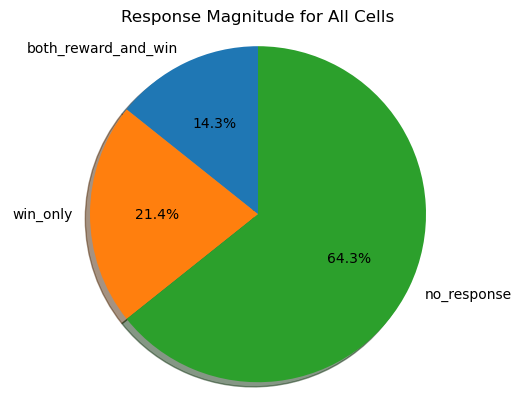

In [101]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(reward_or_win_firing_rate_difference_count.values(), labels=reward_or_win_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()

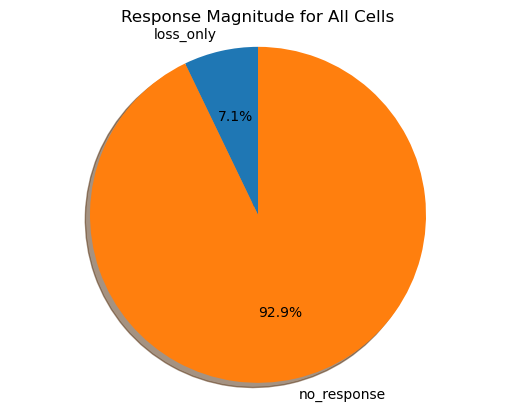

In [102]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:

fig1, ax1 = plt.subplots()
ax1.pie(omission_or_loss_firing_rate_difference_count.values(), labels=omission_or_loss_firing_rate_difference_count.keys(), autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title("Response Magnitude for All Cells")
plt.show()